- System 07 from the VADER dataset
- All available data (>3yrs)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sys import path
path.append('..')
from statistical_clear_sky.algorithm.iterative_fitting import IterativeFitting
from clearsky.utilities import make_time_series
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}
from datetime import datetime

In [3]:
from os.path import expanduser
home = expanduser("~")
with open(home+'/.aws/cassandra_cluster') as f:
    cluster_ip = f.readline().strip('\n')

In [4]:
cluster = Cluster([cluster_ip])
session = cluster.connect('measurements')

In [5]:
cql = """
    select site, meas_name, ts, sensor, meas_val_f 
    from measurement_raw
    where site in ('TADBC1078041')
        and meas_name = 'ac_power';
"""
rows = session.execute(cql)
df = pd.DataFrame(list(rows), )
df.replace(-999999.0, np.NaN, inplace=True)

In [6]:
df = make_time_series(df, return_keys=False).fillna(0)

In [7]:
df.head()

,ac_power_01
2015-04-24 15:10:00,0.3182
2015-04-24 15:15:00,0.3361
2015-04-24 15:20:00,0.3929
2015-04-24 15:25:00,0.3947
2015-04-24 15:30:00,0.4539


In [8]:
days = df.resample('D').max().index[1:-1]
start = days[0]
end = days[-1]
print(start, end)

2015-04-25 00:00:00 2018-11-15 00:00:00


In [9]:
end - start

Timedelta('1300 days 00:00:00')

Note data acquisition system errors (missing data) at the beginning of the data set. The algorithm is robust to errors like this, requiring no special filtering.

/Users/tadatoshi/.pyenv/versions/anaconda3-2018.12/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'kW')

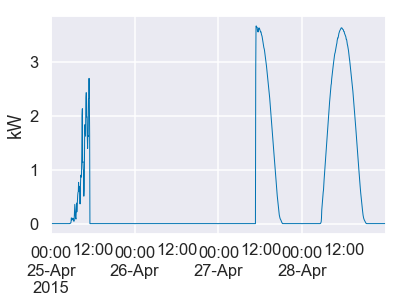

In [10]:
pa = PLOT_ARGS
pa['figsize'] = (6,4)
df.loc[start.strftime('%m/%d/%y'):(start + 3).strftime('%m/%d/%y')].plot(legend=False, **pa)
plt.ylabel('kW')

In [11]:
D = df.loc[start:end].iloc[:-1].values.reshape(288, -1, order='F')
p = df.loc[start:end]

In [12]:
U, Sig, Vt = np.linalg.svd(D, full_matrices=False)
U[:, 0] *= -1
Vt[0] *= -1

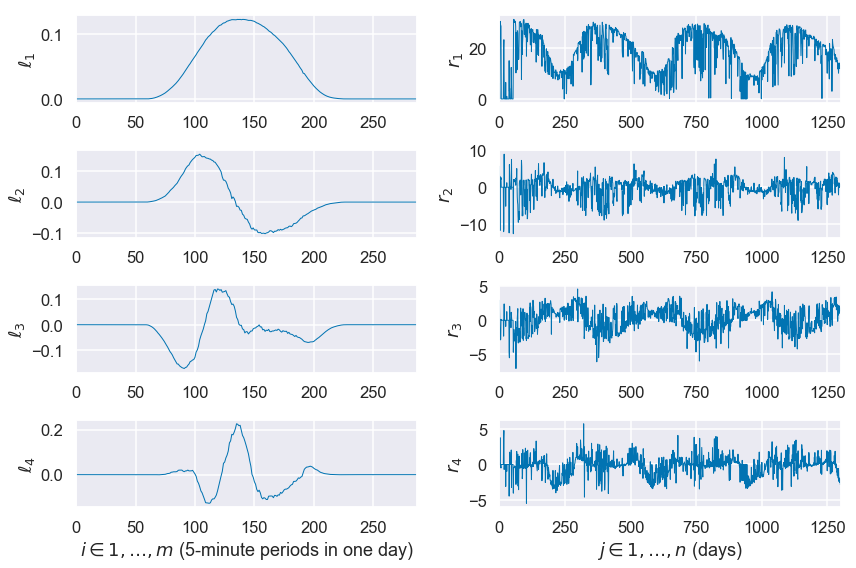

In [13]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,8))
for i in range(4):
    ax[i][0].plot(U.T[i], linewidth=1)
    ax[i][0].set_xlim(0, 287)
    ax[i][0].set_ylabel('$\\ell_{}$'.format(i+1))
    ax[i][1].plot((np.diag(Sig).dot(Vt))[i], linewidth=1)
    ax[i][1].set_xlim(0, D.shape[1])
    ax[i][1].set_ylabel('$r_{}$'.format(i+1))
ax[-1][0].set_xlabel('$i \\in 1, \\ldots, m$ (5-minute periods in one day)')
ax[-1][1].set_xlabel('$j \\in 1, \\ldots, n$ (days)')
plt.tight_layout()
plt.show()

In [14]:
from statistical_clear_sky.solver_type import SolverType
iterative_fitting = IterativeFitting(D, rank_k=6, solver_type=SolverType.mosek)

In [15]:
iterative_fitting.execute(mu_l=5e2, mu_r=1e3, tau=0.9, max_iteration=10)

obtaining initial value of component r0
obtaining weights
starting at 528755.759 [2171.1759047049295, 183.68448929381688, 388776.7729609732, 137624.12552820993]
Miminizing left L matrix
Miminizing right R matrix
iteration 1: 2139.783 [1911.906   20.31   207.567    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 2: 1828.810 [1613.93   18.43  196.45    0.  ]
Miminizing left L matrix
Miminizing right R matrix
iteration 3: 1805.684 [1588.336   22.643  194.704    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 4: 1799.225 [1580.448   24.68   194.096    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 5: 1795.426 [1576.93    25.667  192.828    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 6: 1792.962 [1575.616   26.311  191.036    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 7: 1791.097 [1574.83    26.788  189.479    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 8: 17

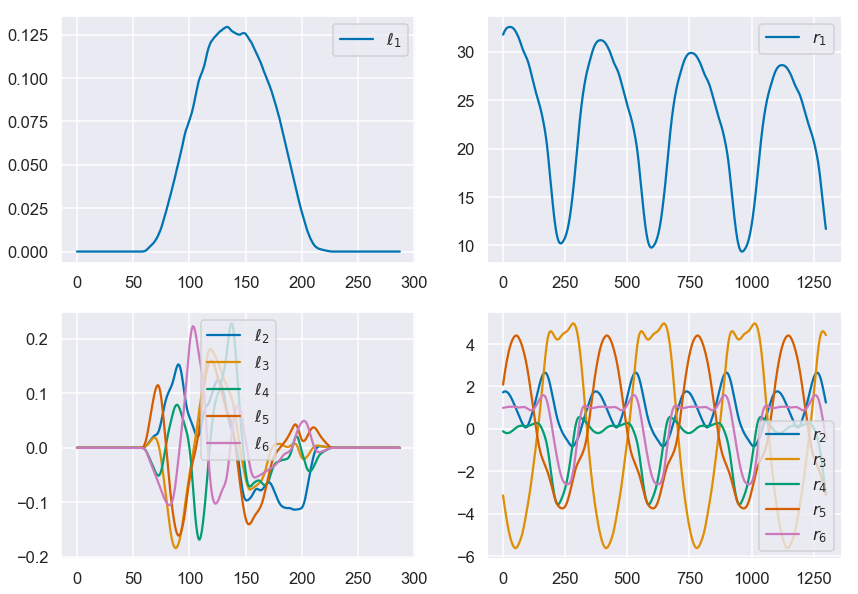

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax[0, 1].plot(iterative_fitting.r_cs_value[0])
ax[1, 1].plot(iterative_fitting.r_cs_value[1:].T)
ax[0, 0].plot(iterative_fitting.l_cs_value[:, 0])
ax[1, 0].plot(iterative_fitting.l_cs_value[:, 1:])
ax[0, 0].legend(['$\\ell_1$'])
ax[1, 0].legend(['$\\ell_{}$'.format(ix) for ix in range(2, iterative_fitting.r_cs_value.shape[0]+1)])
ax[0, 1].legend(['$r_{1}$'])
ax[1, 1].legend(['$r_{}$'.format(ix) for ix in range(2, iterative_fitting.r_cs_value.shape[0]+1)])
plt.show()

Here is the estimated degradation rate (year on year energy-yield) for the system:

In [17]:
iterative_fitting.beta_value

array(-0.04215127)

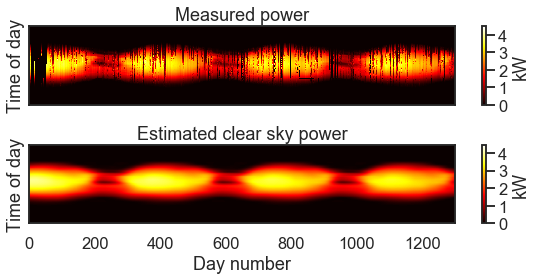

In [19]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(8,4), sharex=True)
    foo = ax[0].imshow(D, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(iterative_fitting.clear_sky_signals(), cmap='hot',
                       vmin=0, vmax=np.max(D), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0], label='kW', ticks=range(5))
    plt.colorbar(bar, ax=ax[1], label='kW', ticks=range(5))
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

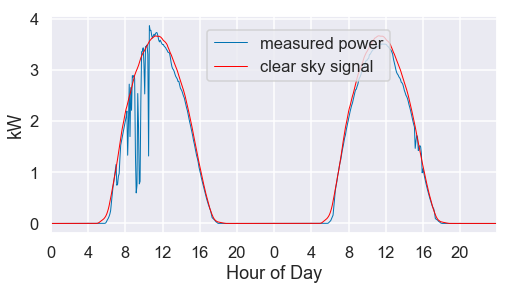

In [20]:
D1 = 340
D2 = D1 + 2
actual = p[D1*288:D2*288].values
clearsky = ((iterative_fitting.clear_sky_signals()))[:, D1:D2].ravel(order='F')
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='measured power')
ax.plot(clearsky, linewidth=1, color='red', label='clear sky signal')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 288*(D2-D1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 288*2, 2*24))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
plt.show()

In [23]:
print(sum(iterative_fitting.l_cs_value.shape) + sum(iterative_fitting.r_cs_value.shape))

1600


(0, 1440)

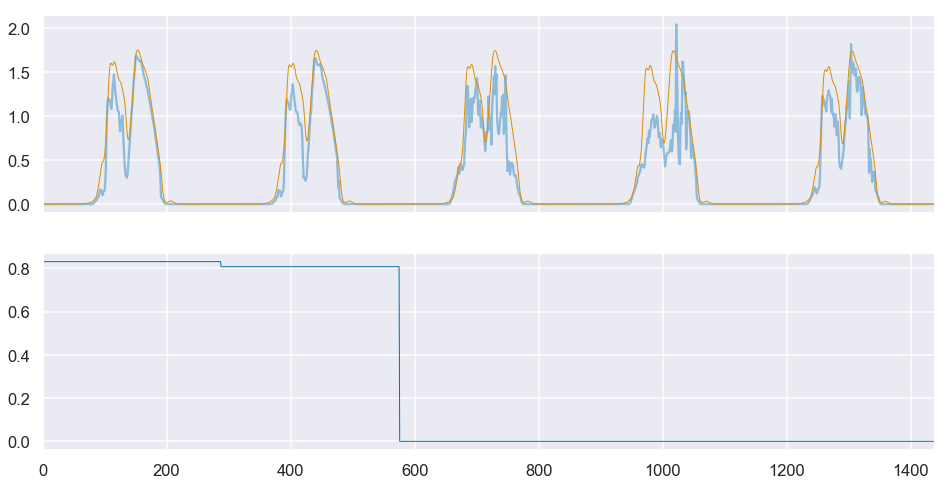

In [25]:
D1 = 220
D2 = D1+5
actual = p[D1*288:D2*288].values
clearsky = ((iterative_fitting.clear_sky_signals()))[:, D1:D2].ravel(order='F')
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(iterative_fitting.weights[D1:D2], 288), linewidth=1)
ax[1].set_xlim(0, 288*(D2-D1))

In [27]:
iterative_fitting.beta_value

array(-0.04215127)

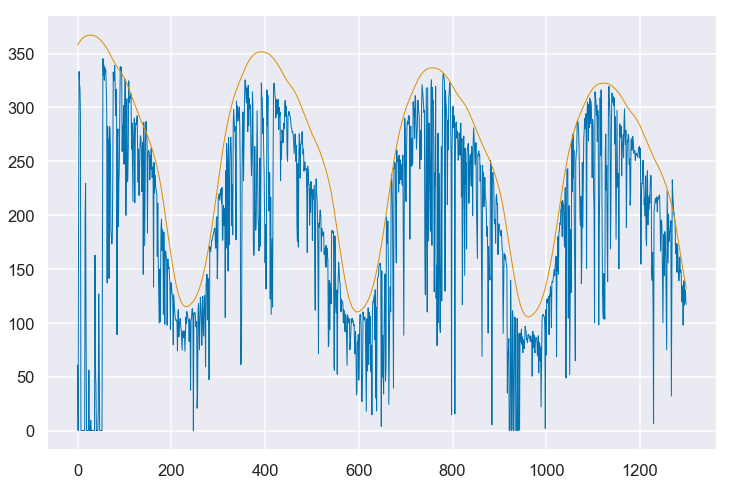

In [28]:
plt.figure(figsize=(12,8))
plt.plot(np.sum(D, axis=0), linewidth=1)
plt.plot(iterative_fitting.r_cs_value[0] * np.sum(iterative_fitting.l_cs_value[:, 0]), linewidth=1)

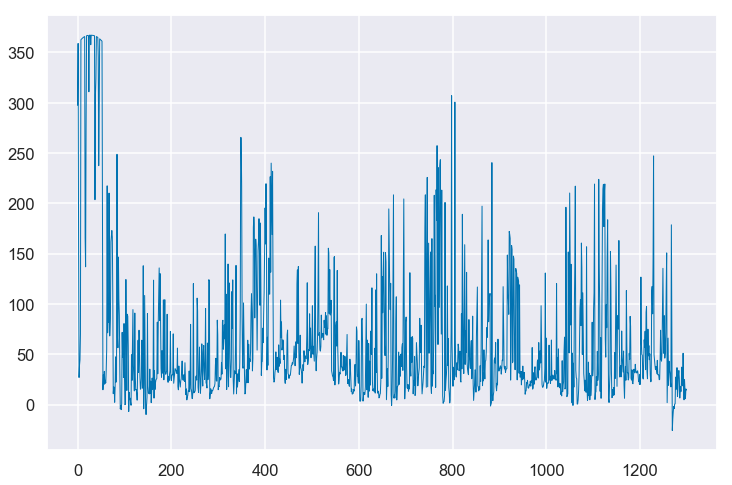

In [29]:
residuals1 = iterative_fitting.r_cs_value[0] * np.sum(iterative_fitting.l_cs_value[:, 0]) - np.sum(D, axis=0)
plt.figure(figsize=(12,8))
plt.plot(residuals1, linewidth=1)

In [33]:
iterative_fitting_2 = IterativeFitting(D, rank_k=6, solver_type=SolverType.mosek)
iterative_fitting_2.execute(mu_l = 5e2, mu_r = 1e3, tau = 0.9, max_iteration=10, is_degradation_calculated=False)

obtaining initial value of component r0
obtaining weights
starting at 528755.759 [2171.1759047049295, 183.68448929381688, 388776.7729609732, 137624.12552820993]
Miminizing left L matrix
Miminizing right R matrix
iteration 1: 2456.963 [2227.351   20.31   209.302    0.   ]
Caution: residuals increased
Miminizing left L matrix
Miminizing right R matrix
iteration 2: 2124.805 [1907.376   19.588  197.841    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 3: 2101.647 [1880.231   24.364  197.052    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 4: 2096.161 [1874.591   25.841  195.729    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 5: 2092.817 [1871.362   26.988  194.467    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 6: 2090.232 [1869.408   27.623  193.202    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 7: 2088.049 [1868.023   28.08   191.946    0.   ]
Miminizing left L matrix
Miminizi

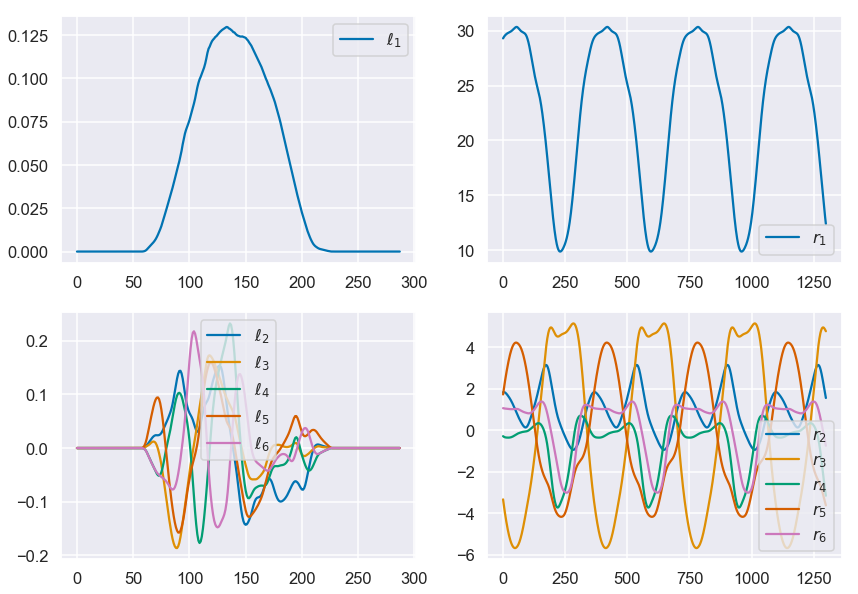

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax[0, 1].plot(iterative_fitting_2.r_cs_value[0])
ax[1, 1].plot(iterative_fitting_2.r_cs_value[1:].T)
ax[0, 0].plot(iterative_fitting_2.l_cs_value[:, 0])
ax[1, 0].plot(iterative_fitting_2.l_cs_value[:, 1:])
ax[0, 0].legend(['$\\ell_1$'])
ax[1, 0].legend(['$\\ell_{}$'.format(ix) for ix in range(2, iterative_fitting_2.r_cs_value.shape[0]+1)])
ax[0, 1].legend(['$r_{1}$'])
ax[1, 1].legend(['$r_{}$'.format(ix) for ix in range(2, iterative_fitting_2.r_cs_value.shape[0]+1)])
plt.show()

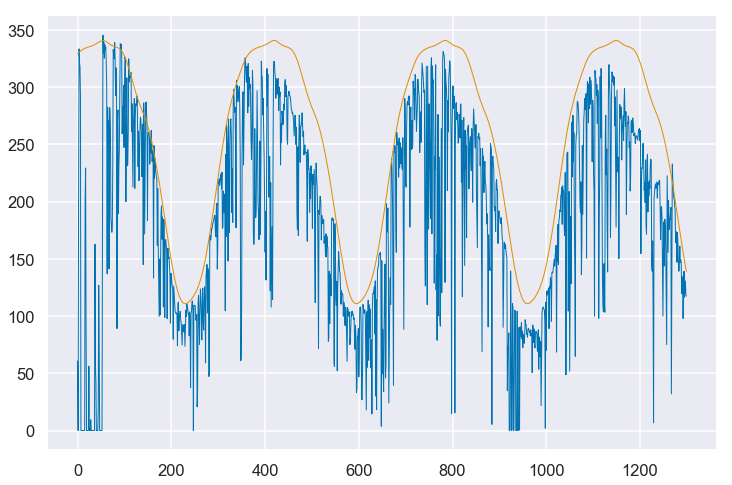

In [35]:
plt.figure(figsize=(12,8))
plt.plot(np.sum(D, axis=0), linewidth=1)
plt.plot(iterative_fitting_2.r_cs_value[0] * np.sum(iterative_fitting_2.l_cs_value[:, 0]), linewidth=1)

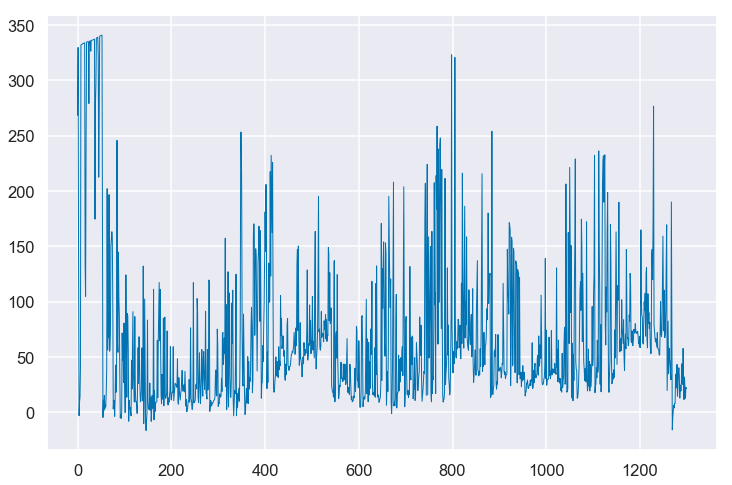

In [36]:
residuals2 = iterative_fitting_2.r_cs_value[0] * np.sum(iterative_fitting_2.l_cs_value[:, 0]) - np.sum(D, axis=0)
plt.figure(figsize=(12,8))
plt.plot(residuals2, linewidth=1)

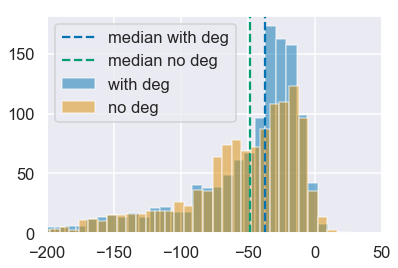

In [37]:
plt.hist(-residuals1, bins=50, alpha=0.5, label='with deg')
plt.hist(-residuals2, bins=50, alpha=0.5, label='no deg')
plt.axvline(np.median(-residuals1), color='b', label='median with deg', ls='--')
plt.axvline(np.median(-residuals2), color='g', label='median no deg', ls='--')
plt.xlim(-200, 50)
plt.legend()
plt.show()

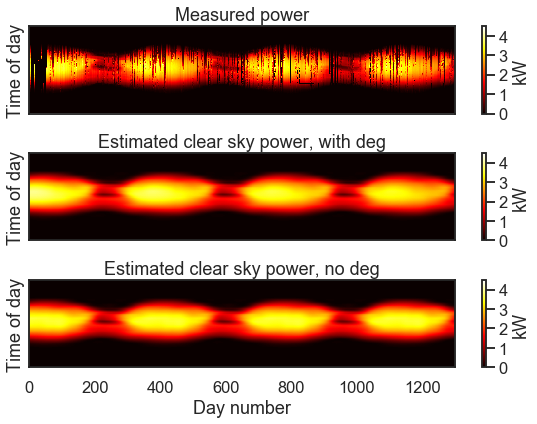

In [38]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=3, figsize=(8,6), sharex=True)
    foo = ax[0].imshow(D, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(iterative_fitting.l_cs_value.dot(iterative_fitting.r_cs_value), cmap='hot',
                       vmin=0, vmax=np.max(D), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power, with deg')
    fbr = ax[2].imshow(iterative_fitting_2.l_cs_value.dot(iterative_fitting_2.r_cs_value), cmap='hot',
                       vmin=0, vmax=np.max(D), interpolation='none', aspect='auto')
    ax[2].set_title('Estimated clear sky power, no deg')
    plt.colorbar(foo, ax=ax[0], label='kW', ticks=range(5))
    plt.colorbar(bar, ax=ax[1], label='kW', ticks=range(5))
    plt.colorbar(fbr, ax=ax[2], label='kW', ticks=range(5))
    ax[-1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    ax[2].set_yticks([])
    ax[2].set_ylabel('Time of day')
    plt.tight_layout()

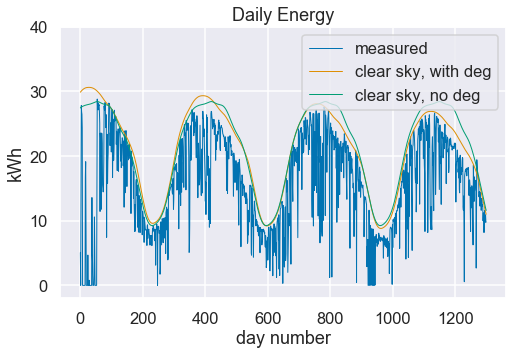

In [39]:
plt.figure(figsize=(8,5))
plt.plot(np.sum(D, axis=0) * 5/60, linewidth=1, label='measured')
plt.plot(iterative_fitting.r_cs_value[0] * np.sum(iterative_fitting.l_cs_value[:, 0]) * 5/60, linewidth=1, label='clear sky, with deg')
plt.plot(iterative_fitting_2.r_cs_value[0] * np.sum(iterative_fitting_2.l_cs_value[:, 0]) * 5/60, linewidth=1, label='clear sky, no deg')
plt.ylim(-2, 40)
plt.legend(loc=1)
plt.title('Daily Energy')
plt.xlabel('day number')
plt.ylabel('kWh')
plt.show()

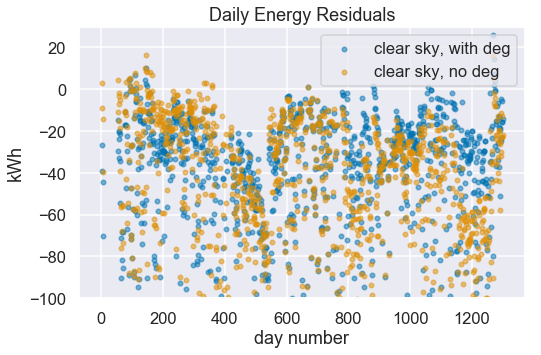

In [40]:
plt.figure(figsize=(8,5))
plt.scatter(range(len(residuals1)), -residuals1, marker='.', alpha=0.5, label='clear sky, with deg')
plt.scatter(range(len(residuals2)), -residuals2, marker='.', alpha=0.5, label='clear sky, no deg')
plt.ylim(-100, 30)
plt.legend(loc=1)
plt.title('Daily Energy Residuals')
plt.xlabel('day number')
plt.ylabel('kWh')
plt.show()